In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import gensim
import string 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [2]:
df = pd.read_csv('data/all_opinions.csv')

In [3]:
df.shape

(35781, 14)

In [4]:
df.dtypes

author_name                 object
category                    object
per_curiam                    bool
case_name                   object
date_filed                  object
federal_cite_one            object
absolute_url                object
cluster                     object
year_filed                   int64
scdb_id                     object
scdb_decision_direction    float64
scdb_votes_majority        float64
scdb_votes_minority        float64
text                        object
dtype: object

In [5]:
df.sample(1)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
30719,Justice Blatchford,majority,False,Lovell Mfg. Co. v. Cary,1893-03-06,147 U.S. 623,https://www.courtlistener.com/opinion/93517/lo...,https://www.courtlistener.com/api/rest/v3/clus...,1893,1892-106,2.0,6.0,0.0,"This is a suit in equity, brought March 14, 18..."


# Logistic Regression without preprocessing

In [6]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text'])
y = df['per_curiam'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

Accuracy: 0.96
Precision: 0.8
Recall: 0.77 



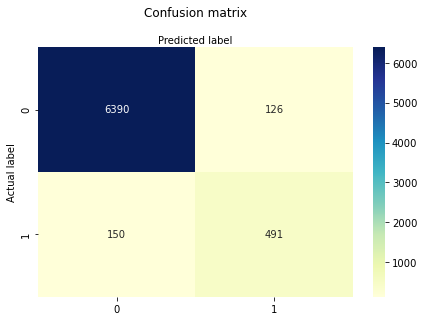

In [7]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [False, True] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, y_pred),2), "\n")

In [8]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      6516
        True       0.80      0.77      0.78       641

    accuracy                           0.96      7157
   macro avg       0.89      0.87      0.88      7157
weighted avg       0.96      0.96      0.96      7157



# Naive Bayes without preprocessing

In [9]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
nb_y_pred = clf.predict(X_test)

Accuracy: 0.93
Precision: 0.57
Recall: 0.8 



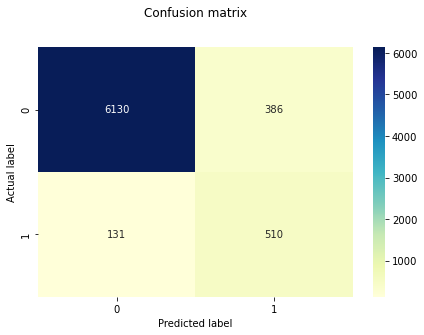

In [10]:
cnf_matrix = metrics.confusion_matrix(y_test, nb_y_pred)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, nb_y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, nb_y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, nb_y_pred),2), "\n")

In [11]:
print(classification_report(y_test, nb_y_pred))

              precision    recall  f1-score   support

       False       0.98      0.94      0.96      6516
        True       0.57      0.80      0.66       641

    accuracy                           0.93      7157
   macro avg       0.77      0.87      0.81      7157
weighted avg       0.94      0.93      0.93      7157



# Preprocessing


Removal of NA

In [12]:
# df.dropna(inplace = True)
# df.shape

Lower Casing

In [13]:
df["text_lower"] = df["text"].str.lower()
df.head(1)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,text_lower
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,there is no right more basic in our democracy ...


Removal of Punctuations

In [14]:
# import string library function  
import string  

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["text_lower_wo_punct"] = df["text_lower"].apply(lambda text: remove_punctuation(text))
df.head(1)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,text_lower,text_lower_wo_punct
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,there is no right more basic in our democracy ...,there is no right more basic in our democracy ...


Removal of stopwords

In [15]:
from nltk.corpus import stopwords
stop_list = stopwords.words('english')

stop_list += ['court', 'law', 'claim', 'state', 'made', 'case', 'act', 'city', 'right', 'rights', 'defendant', 'may', 
              'would', 'one', 'plaintiff', 'upon', 'upon', 'said', 'shall', 'time', 'property', 'could', 'question', 'part', 'fact', 'company', 'held', 'statute', 'united', 'also', 'contract', 'order', 'land', 'power', 'must', 'judgment', '\x97', 'party', 'make', 'without', 'whether', 'subject', 'might', 'purpose', 'provision', 'v.', 'congress', 'decision', 'court,', 'first', 'action', 'interest', 'evidence', 'within', 'two', 'tax', 'authority', 'case,', 'effect', 'person', 'it,', 'government', 'opinion', 'given', 'general', 'use', 'certain', 'cannot', 'that,', 'respect', 'required', 'amount', 'present', 'jurisdiction', 'thus', 'suit', 'proceeding', 'either', 'matter', 'found', 'rule', 'section', 'sale', 'term', 'state,', 'duty', 'title', 'district', 'ground', 'payment', '"the', 'well', 'reason', 'commission', 'it.', 'united_states,', 'decree', 'charge', 'view', 'and,', 'grant', 'corporation', 'paid', 'new', 'taken', 'application', 'point', 'necessary', 'bank', 'another', 'show', 'condition', 'provided', 'used', 'give', 'unless']

# Retain word if word is not found in stop list
df['text_lower_wo_punct'] = df['text_lower_wo_punct'].apply(lambda text: " ".join([word for word in str(text).split() if word not in stop_list]))              

In [16]:
df.head(1)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,text_lower,text_lower_wo_punct
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,there is no right more basic in our democracy ...,basic democracy participate electing political...


In [17]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text_lower_wo_punct'])
y = df['per_curiam'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

Lemmatization

In [18]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

df['text_lower_wo_punct']= df['text_lower_wo_punct'].apply(lambda text: " ".join([lemmatizer.lemmatize(word) for word in str(text).split() if lemmatizer.lemmatize(word) not in stop_list]))

In [19]:
df.head(3)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text,text_lower,text_lower_wo_punct
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...,there is no right more basic in our democracy ...,basic democracy participate electing political...
1,Justice Thomas,concurring,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,I adhere to the view that this Court’s decisio...,i adhere to the view that this court’s decisio...,adhere court’s buckley v valeo 424 u 1 1976 pe...
2,Justice Breyer,dissenting,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,"Nearly 40 years ago in Buckley v. Valeo, 424 U...","nearly 40 years ago in buckley v. valeo, 424 u...",nearly 40 year ago buckley v valeo 424 u 1 197...


Logistic Regegression post text pre-processing

In [20]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['text_lower_wo_punct'])
y = df['per_curiam'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)

Accuracy: 0.96
Precision: 0.76
Recall: 0.75 



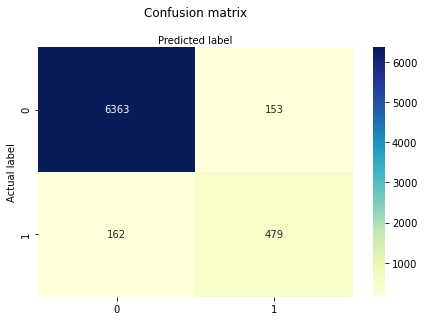

In [21]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names = [False, True] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, y_pred),2), "\n")

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.98      0.98      0.98      6516
        True       0.76      0.75      0.75       641

    accuracy                           0.96      7157
   macro avg       0.87      0.86      0.86      7157
weighted avg       0.96      0.96      0.96      7157



Naive Bayes Post text pre-processing

In [23]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
nb_y_pred = clf.predict(X_test)

Accuracy: 0.96
Precision: 0.91
Recall: 0.56 



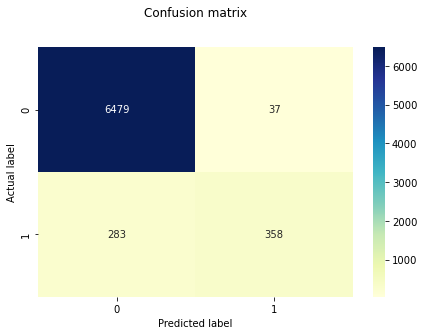

In [24]:
cnf_matrix = metrics.confusion_matrix(y_test, nb_y_pred)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:", round(metrics.accuracy_score(y_test, nb_y_pred),2))
print("Precision:", round(metrics.precision_score(y_test, nb_y_pred),2))
print("Recall:", round(metrics.recall_score(y_test, nb_y_pred),2), "\n")

In [25]:
print(classification_report(y_test, nb_y_pred))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98      6516
        True       0.91      0.56      0.69       641

    accuracy                           0.96      7157
   macro avg       0.93      0.78      0.83      7157
weighted avg       0.95      0.96      0.95      7157



In [19]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import pandas as pd

In [20]:
df = pd.read_csv('data/all_opinions.csv')
df.head(1)

,author_name,category,per_curiam,case_name,date_filed,federal_cite_one,absolute_url,cluster,year_filed,scdb_id,scdb_decision_direction,scdb_votes_majority,scdb_votes_minority,text
0,Justice Roberts,majority,False,McCutcheon v. Federal Election Comm'n,2014-04-02,NaN,https://www.courtlistener.com/opinion/2659301/...,https://www.courtlistener.com/api/rest/v3/clus...,2014,2013-033,1.0,5.0,4.0,There is no right more basic in our democracy ...


In [21]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500

EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 509633 unique tokens.


In [22]:
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (35781, 500)


In [23]:
from sklearn.model_selection import train_test_split

y = df['per_curiam'].tolist()

Y = pd.get_dummies(df['per_curiam']).values
print('Shape of label tensor:', Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 0)

Shape of label tensor: (35781, 2)


In [24]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 10
batch_size = 100

results = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
258/258 [==============================] - 1527s 6s/step - loss: 0.2664 - accuracy: 0.9158 - val_loss: 0.1494 - val_accuracy: 0.9567
Epoch 2/10
258/258 [==============================] - 1577s 6s/step - loss: 0.1336 - accuracy: 0.9573 - val_loss: 0.1400 - val_accuracy: 0.9602
Epoch 3/10
258/258 [==============================] - 1569s 6s/step - loss: 0.0962 - accuracy: 0.9693 - val_loss: 0.1335 - val_accuracy: 0.9609
Epoch 4/10
258/258 [==============================] - 1575s 6s/step - loss: 0.0687 - accuracy: 0.9792 - val_loss: 0.1356 - val_accuracy: 0.9609
Epoch 5/10
258/258 [==============================] - 1603s 6s/step - loss: 0.0523 - accuracy: 0.9846 - val_loss: 0.1548 - val_accuracy: 0.9504
Epoch 6/10
258/258 [==============================] - 1580s 6s/step - loss: 0.0324 - accuracy: 0.9907 - val_loss: 0.1678 - val_accuracy: 0.9647


In [25]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

224/224 [==============================] - 42s 185ms/step - loss: 0.1739 - accuracy: 0.9613
Test set
  Loss: 0.174
  Accuracy: 0.961


In [26]:
# import gensim 

# doc = df['text'].values.tolist()
# bi = gensim.models.phrases.Phrases(doc, min_count=3, threshold=10)
# tri = gensim.models.phrases.Phrases(bi[doc], min_count=3, threshold=10)
# df['text'] = tri[bi[doc]]

In [27]:
# df.head(1)

Find common words

In [28]:
from collections import Counter
import numpy as np

# doc_lemma = df_lemma['text'].values.tolist()

# term_list = []

# for each_word in doc_lemma:
#     term_list += each_word

# Counter = Counter(term_list) 
  
# # most_common() produces k frequently encountered 
# # input values and their respective counts. 
# top_occuring_words = Counter.most_common(100) 

# # print("Top 100 reoccuring words: ", top_occuring_words)

# def convert(word_count_tuple, dic): 
#     for a, b in word_count_tuple: 
#         dic.setdefault(a, []).append(b) 
#     return dic

In [29]:
# top_occuring_word_dic = {}
# top_occuring_word_dic = convert(top_occuring_words, top_occuring_word_dic)

In [30]:
# print(doc_lemma[0])